##intro

In [1]:
# install package

import h5py
import numpy as np
import matplotlib.pylab as py
import random
import datetime
%matplotlib inline

import torch
import torch.optim as optim

import time
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from numpy import savetxt
from numpy import loadtxt

In [2]:
!wget 'https://raw.githubusercontent.com/rcpaffenroth/DS595-Machine-Learning-for-Engineering-and-Science-Applications/main/data/cs3data1.h5'
!wget 'https://raw.githubusercontent.com/rcpaffenroth/DS595-Machine-Learning-for-Engineering-and-Science-Applications/main/data/cs3data2.h5'

--2022-03-31 19:16:51--  https://raw.githubusercontent.com/rcpaffenroth/DS595-Machine-Learning-for-Engineering-and-Science-Applications/main/data/cs3data1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1549768 (1.5M) [application/octet-stream]
Saving to: ‘cs3data1.h5’

cs3data1.h5         100%[===================>]   1.48M  --.-KB/s    in 0.03s   

2022-03-31 19:16:51 (56.9 MB/s) - ‘cs3data1.h5’ saved [1549768/1549768]

--2022-03-31 19:16:51--  https://raw.githubusercontent.com/rcpaffenroth/DS595-Machine-Learning-for-Engineering-and-Science-Applications/main/data/cs3data2.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconte

In [3]:
arrays={}

# grab the data from the file
filepath = ['cs3data1.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        arrays[k] = v

# display what data we have
for key in arrays.keys():
    print(key, arrays[key])

duct_height_save <HDF5 dataset "duct_height_save": shape (1, 1), type "<f8">
field_H_imag_save <HDF5 dataset "field_H_imag_save": shape (1201, 40), type "<f8">
field_H_real_save <HDF5 dataset "field_H_real_save": shape (1201, 40), type "<f8">
field_V_imag_save <HDF5 dataset "field_V_imag_save": shape (1201, 40), type "<f8">
field_V_real_save <HDF5 dataset "field_V_real_save": shape (1201, 40), type "<f8">
range_grid <HDF5 dataset "range_grid": shape (1201, 1), type "<f8">


In [4]:
numranges = 1201

# get the electric field data and reshape everything into one np array

data_h_real = np.array(arrays['field_H_real_save']).reshape(numranges, 40)
data_h_imag = np.array(arrays['field_H_imag_save']).reshape(numranges, 40)
data_v_real = np.array(arrays['field_V_real_save']).reshape(numranges, 40)
data_v_imag = np.array(arrays['field_V_imag_save']).reshape(numranges, 40)

Xraw = []
Xraw += [[data_h_real*1, data_h_imag*1, data_v_real*1, data_v_imag*1]]
Xraw = np.block(Xraw)

print(Xraw.shape)

# get the range data
ranges = np.zeros((numranges))
ranges = np.array(arrays['range_grid']).reshape((numranges))

yraw = []
yraw += [ranges]
yraw = np.block(yraw)

print(yraw.shape)

(1201, 160)
(1201,)


<Figure size 432x288 with 0 Axes>

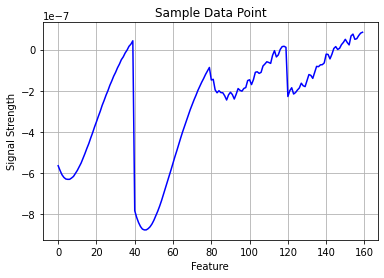

<Figure size 432x288 with 0 Axes>

In [5]:
plt.plot(Xraw[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

In [6]:
def normalize(X):

  normedX = np.zeros_like(X)

  #renormalize
  normedX[:,0:80] = X[:,0:80] / np.linalg.norm(X[:,0:80], axis = 1, keepdims=True).reshape((len(X), 1))
  normedX[:,80:160] = X[:,80:160] / np.linalg.norm(X[:,80:160], axis = 1, keepdims=True).reshape((len(X), 1))

  return normedX


In [7]:
x_norm=normalize(Xraw)

<Figure size 432x288 with 0 Axes>

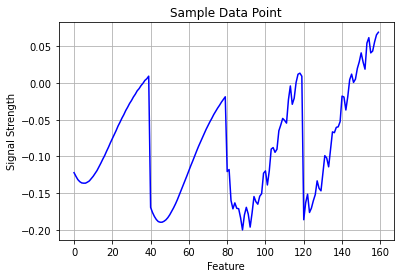

<Figure size 432x288 with 0 Axes>

In [8]:
plt.plot(x_norm[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

In [9]:
from sklearn.model_selection import train_test_split
XTrain,XTest = train_test_split(x_norm, test_size=0.5, shuffle=True, random_state=1)
yTrain,yTest = train_test_split(yraw, test_size=0.5, shuffle=True,random_state=1)

print(XTrain.shape)
print(XTest.shape)
print(yTrain.shape)
print(yTest.shape)

(600, 160)
(601, 160)
(600,)
(601,)


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import linear_model

In [11]:
def train(XTrain,XTest,yTrain,yTest):
    method = linear_model.LinearRegression()
    model = method.fit(XTrain, yTrain)

    y_pred_train=method.predict(XTrain)
    y_pred_test=method.predict(XTest)

    MAE_train=mean_absolute_error(y_pred_train,yTrain)
    MSE_train=mean_squared_error(y_pred_train,yTrain)
    RMSE_train=np.sqrt(mean_squared_error(y_pred_train,yTrain))
    R2_train=r2_score(y_pred_train,yTrain)

    MAE_test=mean_absolute_error(y_pred_test,yTest)
    MSE_test=mean_squared_error(y_pred_test,yTest)
    RMSE_test=np.sqrt(mean_squared_error(y_pred_test,yTest))
    R2_test=r2_score(y_pred_test,yTest)

    return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [12]:
from tabulate import tabulate
MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test=train(XTrain,XTest,yTrain,yTest)
results=[["Linear regression",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test]]

In [13]:
print(tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R2", "Test MAE", "Test MSE", "Test RMSE", "Test R2"], tablefmt="grid"))

+-------------------+----------------+----------------+-----------------+---------------+-------------+-------------+-------------+--------------+
| Model             |   Training MAE |   Training MSE |   Training RMSE |   Training R2 |    Test MAE |    Test MSE |   Test RMSE |      Test R2 |
+===================+================+================+=================+===============+=============+=============+=============+==============+
| Linear regression |        10765.5 |    1.88684e+08 |         13736.2 |      -0.81852 | 1.27881e+06 | 1.35899e+14 | 1.16576e+07 | -0.000280507 |
+-------------------+----------------+----------------+-----------------+---------------+-------------+-------------+-------------+--------------+


##Answer 1
####Part 1
- R^2 is a value between 0 and 100%. It is the fraction of response variance captured by the
regression model. This can be found by dividing the total variance explained by the model by the
total variance. An R^2 value of 100% would mean the two variables are perfectly correlated. 
- MSE is the mean squared error, the residual error, found by the average of the squared errors. A large MSE would mean a large variance and 0 would mean the two variables are perfectly correlated.
- MAE is the mean absolute error, one of the most commonly used loss functions for regression problems, MAE helps users to formulate learning problems into optimization problems. It also serves as an easy-to-understand quantifiable measurement of errors for regression problems.
- RMSE is root of the mean of squared errors. Root mean square error or root mean square deviation is one of the most commonly used measures for evaluating the quality of predictions. It shows how far predictions fall from measured true values using Euclidean distance. To compute RMSE, calculate the residual (difference between prediction and truth) for each data point, compute the norm of residual for each data point, compute the mean of residuals and take the square root of that mean. RMSE is commonly used in supervised learning applications, as RMSE uses and needs true measurements at each predicted data point.


MSE, RMSE, MAE can vary if the response variable is scaled which is why R^2 can give a better idea of the performance of an algorithm.


####Part 2


In [14]:
def train1(XTrain,XTest,yTrain,yTest):
    method1 = linear_model.Ridge()
    model1 = method1.fit(XTrain, yTrain)

    y_pred_train_R=method1.predict(XTrain)
    y_pred_test_R=method1.predict(XTest)

    MAE_train_R=mean_absolute_error(y_pred_train_R,yTrain)
    MSE_train_R=mean_squared_error(y_pred_train_R,yTrain)
    RMSE_train_R=np.sqrt(mean_squared_error(y_pred_train_R,yTrain))
    R2_train_R=r2_score(y_pred_train_R,yTrain)

    MAE_test_R=mean_absolute_error(y_pred_test_R,yTest)
    MSE_test_R=mean_squared_error(y_pred_test_R,yTest)
    RMSE_test_R=np.sqrt(mean_squared_error(y_pred_test_R,yTest))
    R2_test_R=r2_score(y_pred_test_R,yTest)

    return MAE_train_R,MSE_train_R,RMSE_train_R,R2_train_R,MAE_test_R,MSE_test_R,RMSE_test_R,R2_test_R

In [15]:
MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test=train1(XTrain,XTest,yTrain,yTest)

results.append(["Linear Ridge",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])


In [16]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+-------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Model             |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |        Test MAE |    Test MSE |       Test RMSE |       Test R^2 |
+===================+================+================+=================+================+=================+=============+=================+================+
| Linear regression |        10765.5 |    1.88684e+08 |         13736.2 |       -0.81852 |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |   -0.000280507 |
+-------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Linear Ridge      |        14682.5 |    2.90253e+08 |         17036.8 |     -523.532   | 15361.8         | 3.11941e+08 | 17661.9         | -633.494       |
+-------------------+----------------+--------------

In [17]:
def train2(XTrain,XTest,yTrain,yTest):
    method2 = linear_model.Lasso()
    model2 = method2.fit(XTrain, yTrain)

    y_pred_train_L=method2.predict(XTrain)
    y_pred_test_L=method2.predict(XTest)

    MAE_train_L=mean_absolute_error(y_pred_train_L,yTrain)
    MSE_train_L=mean_squared_error(y_pred_train_L,yTrain)
    RMSE_train_L=np.sqrt(mean_squared_error(y_pred_train_L,yTrain))
    R2_train_L=r2_score(y_pred_train_L,yTrain)

    MAE_test_L=mean_absolute_error(y_pred_test_L,yTest)
    MSE_test_L=mean_squared_error(y_pred_test_L,yTest)
    RMSE_test_L=np.sqrt(mean_squared_error(y_pred_test_L,yTest))
    R2_test_L=r2_score(y_pred_test_L,yTest)

    return MAE_train_L,MSE_train_L,RMSE_train_L,R2_train_L,MAE_test_L,MSE_test_L,RMSE_test_L,R2_test_L

In [18]:
MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test=train2(XTrain,XTest,yTrain,yTest)

results.append(["Linear Lasso",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])


In [19]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+-------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Model             |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |        Test MAE |    Test MSE |       Test RMSE |       Test R^2 |
+===================+================+================+=================+================+=================+=============+=================+================+
| Linear regression |        10765.5 |    1.88684e+08 |         13736.2 |       -0.81852 |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |   -0.000280507 |
+-------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Linear Ridge      |        14682.5 |    2.90253e+08 |         17036.8 |     -523.532   | 15361.8         | 3.11941e+08 | 17661.9         | -633.494       |
+-------------------+----------------+--------------

In [20]:
def train3(XTrain,XTest,yTrain,yTest):
    method3 = linear_model.BayesianRidge()
    model3 = method3.fit(XTrain, yTrain)

    y_pred_train_B=method3.predict(XTrain)
    y_pred_test_B=method3.predict(XTest)

    MAE_train_B=mean_absolute_error(y_pred_train_B,yTrain)
    MSE_train_B=mean_squared_error(y_pred_train_B,yTrain)
    RMSE_train_B=np.sqrt(mean_squared_error(y_pred_train_B,yTrain))
    R2_train_B=r2_score(y_pred_train_B,yTrain)

    MAE_test_B=mean_absolute_error(y_pred_test_B,yTest)
    MSE_test_B=mean_squared_error(y_pred_test_B,yTest)
    RMSE_test_B=np.sqrt(mean_squared_error(y_pred_test_B,yTest))
    R2_test_B=r2_score(y_pred_test_B,yTest)

    return MAE_train_B,MSE_train_B,RMSE_train_B,R2_train_B,MAE_test_B,MSE_test_B,RMSE_test_B,R2_test_B

In [21]:
MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test=train3(XTrain,XTest,yTrain,yTest)

results.append(["Linear BayesianRidge",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])

print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+----------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Model                |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |        Test MAE |    Test MSE |       Test RMSE |       Test R^2 |
+======================+================+================+=================+================+=================+=============+=================+================+
| Linear regression    |        10765.5 |    1.88684e+08 |         13736.2 |   -0.81852     |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |   -0.000280507 |
+----------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Linear Ridge         |        14682.5 |    2.90253e+08 |         17036.8 | -523.532       | 15361.8         | 3.11941e+08 | 17661.9         | -633.494       |
+----------------------+----------

##Answer 2)
####Part 1
1. Human Intervention: Machine learning requires more ongoing human intervention to get results. Deep learning is more complex to set up but requires minimal intervention thereafter.

2. Hardware: Machine learning programs tend to be less complex than deep learning algorithms and can often run on conventional computers, but deep learning systems require far more powerful hardware and resources. This demand for power has driven has meant increased use of graphical processing units. GPUs are useful for their high bandwidth memory and ability to hide latency (delays) in memory transfer due to thread parallelism (the ability of many operations to run efficiently at the same time.)

3. Time: Machine learning systems can be set up and operate quickly but may be limited in the power of their results. Deep learning systems take more time to set up but can generate results instantaneously (although the quality is likely to improve over time as more data becomes available).

4. Approach: Machine learning tends to require structured data and uses traditional algorithms like linear regression. Deep learning employs neural networks and is built to accommodate large volumes of unstructured data.

5. Applications: Machine learning is already in use in your email inbox, bank, and doctor’s office. Deep learning technology enables more complex and autonomous programs, like self-driving cars or robots that perform advanced surgery

\\

####Part 2
The main difference between CPU and GPU architecture is that a CPU is designed to handle a wide-range of tasks quickly (as measured by CPU clock speed), but are limited in the concurrency of tasks that can be running. A GPU is designed to quickly render high-resolution images and video concurrently.

Because GPUs can perform parallel operations on multiple sets of data, they are also commonly used for non-graphical tasks such as machine learning and scientific computation. Designed with thousands of processor cores running simultaneously, GPUs enable massive parallelism where each core is focused on making efficient calculations.

\\
While GPUs can process data several orders of magnitude faster than a CPU due to massive parallelism, GPUs are not as versatile as CPUs. CPUs have large and broad instruction sets, managing every input and output of a computer, which a GPU cannot do. In a server environment, there might be 24 to 48 very fast CPU cores. Adding 4 to 8 GPUs to this same server can provide as many as 40,000 additional cores. While individual CPU cores are faster (as measured by CPU clock speed) and smarter than individual GPU cores (as measured by available instruction sets), the sheer number of GPU cores and the massive amount of parallelism that they offer more than make up the single-core clock speed difference and limited instruction sets.

\\

####Part 3
GPUs are best suited for repetitive and highly-parallel computing tasks. Beyond video rendering, GPUs excel in machine learning, financial simulations and risk modeling, and many other types of scientific computations. While in years past, GPUs were used for mining cryptocurrencies such as Bitcoin or Ethereum, GPUs are generally no longer utilized at scale, giving way to specialized hardware such as Field-Programmable Grid Arrays (FPGA) and then Application Specific Integrated Circuits (ASIC).



In [22]:
if torch.cuda.is_available():
  print('CUDA available')
  print(torch.cuda.get_device_name(0))
else:
  print('CUDA *not* available')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

CUDA available
Tesla K80


In [23]:
class mynetwork_1(nn.Module):
  def __init__(self):
    super(mynetwork_1, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160, 50), nn.Linear(50, 1))
  
  def forward(self, x):
    x = self.structure(x)
    return x

In [24]:
class mynetwork_2(nn.Module):
  def __init__(self):
    super(mynetwork_2, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160, 50), nn.Sigmoid(), nn.Linear(50, 1))
  def forward(self, x):
    x = self.structure(x)
    return x

##Answer 3)
####Part 1
The sigmoid function is used as an activation function in neural networks. When the activation function for a neuron is a sigmoid function it is a guarantee that the output of this unit will always be between 0 and 1. Also, as the sigmoid is a non-linear function, the output of this unit would be a non-linear function of the weighted sum of inputs. Such a neuron that employs a sigmoid function as an activation function is termed as a sigmoid unit.

\\
If we use a linear activation function in a neural network (Our First Network), then this model can only learn linearly separable problems. However, with the addition of just one hidden layer and a sigmoid activation function in the hidden layer (Our Second Network), the neural network can easily learn a non-linearly separable problem. Using a non-linear function produces non-linear boundaries and hence, the sigmoid function can be used in neural networks for learning complex decision functions.



##Answer 4
####Part 1
Gradient descent is a first-order optimization algorithm which is dependent on the first order derivative of a loss function. It calculates that which way the weights should be altered so that the function can reach a minima. Through backpropagation, the loss is transferred from one layer to another and the model’s parameters also known as weights are modified depending on the losses so that the loss can be minimized.

algorithm: θ=θ−α⋅∇J(θ)

No, Gradient Descent does not always guarantee to find the global minima. It finds the minima but it need not to be global minima. We could have a small learning rate which make us think we have reached optimal minima but in reality we are stuck in local minima. We could have large Learning rate which can skip the minima.

####Part 2
1. Batch Size: The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

 Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.

2. Number of epochs: The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

 One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm.
3. Learing rate: This is the hyperparameter that determines the steps the gradient descent algorithm takes. Gradient Descent is too sensitive to the learning rate. If it is too big, the algorithm may bypass the local minimum and overshoot. If it too small, it might increase the total computation time to a very large extent.
4. Criterion (loss function): A function that returns the cost associated with the model and measures how well our model is doing on the training data. If the cost is too high, it means that the predictions by our model are deviating too much from the observed data. In any machine learning algorithm, our ultimate mission is to minimize the loss function.

\\
Each of them impact our model. Learning rate will set the computational time. if we have large learning rate we might skip minima. If number of epochs are larger or small it will imapact our network. Large will cause overfitting and less will cause underfitting.

In [25]:
torch.manual_seed(50)

model_1 = mynetwork_1().cuda()
model_2 = mynetwork_2().cuda()


batch_size = 100
num_epochs = 500
learning_rate = 1e-3
criterion = nn.MSELoss()

print_interval=20

In [26]:
def train(training_inputs, training_outputs, network, epochs, learning_rate, batch_size, loss_function, print_interval):
  train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(training_inputs), torch.Tensor(training_outputs))
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-5)
  track_losses = np.zeros(num_epochs)

  start = time.time()
  for epoch in range(1, num_epochs):

    for batch_idx, (X, y) in enumerate(train_loader):
      data = X
      output = network(data.to(device))
      loss = loss_function(output, y.view([-1, 1]).to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    training_loss = loss.item()**.5
    track_losses[epoch-1]=training_loss
    if epoch % print_interval == 0:
      print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))

  return network, track_losses

In [27]:
network_1, losses = train(XTrain, yTrain, model_1, num_epochs, learning_rate, batch_size, criterion, print_interval)
network_2, losses = train(XTrain, yTrain, model_2, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.352e+04 time:    0.7
epoch:   40 training loss: 4.311e+04 time:    1.1
epoch:   60 training loss: 4.254e+04 time:    1.6
epoch:   80 training loss: 4.564e+04 time:    2.1
epoch:  100 training loss: 4.338e+04 time:    2.5
epoch:  120 training loss: 4.120e+04 time:    3.0
epoch:  140 training loss: 4.542e+04 time:    3.5
epoch:  160 training loss: 4.226e+04 time:    3.9
epoch:  180 training loss: 4.191e+04 time:    4.7
epoch:  200 training loss: 4.350e+04 time:    5.1
epoch:  220 training loss: 4.272e+04 time:    5.3
epoch:  240 training loss: 4.434e+04 time:    5.6
epoch:  260 training loss: 4.217e+04 time:    5.9
epoch:  280 training loss: 4.516e+04 time:    6.2
epoch:  300 training loss: 4.234e+04 time:    6.4
epoch:  320 training loss: 4.353e+04 time:    6.7
epoch:  340 training loss: 4.416e+04 time:    7.0
epoch:  360 training loss: 4.318e+04 time:    7.3
epoch:  380 training loss: 4.250e+04 time:    7.6
epoch:  400 training loss: 4.079e+04 time:    7.8


In [28]:
def model_eva(XTrain,XTest,yTrain,yTest,model):
  XTrain_th=torch.FloatTensor(XTrain).cuda()
  Xtest_th=torch.FloatTensor(XTest).cuda()

  yTrain_pred_np=model(XTrain_th).cpu().detach().numpy().reshape(-1)
  yTest_pred_np=model(Xtest_th).cpu().detach().numpy().reshape(-1)

  MAE_train=mean_absolute_error(yTrain_pred_np,yTrain)
  MSE_train=mean_squared_error(yTrain_pred_np,yTrain)
  RMSE_train=np.sqrt(mean_squared_error(yTrain_pred_np,yTrain))
  R2_train=r2_score(yTrain_pred_np,yTrain)

  MAE_test=mean_absolute_error(yTest_pred_np,yTest)
  MSE_test=mean_squared_error(yTest_pred_np,yTest)
  RMSE_test=np.sqrt(mean_squared_error(yTest_pred_np,yTest))
  R2_test=r2_score(yTest_pred_np,yTest)

  return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [29]:
MAE_train_nn1,MSE_train_nn1,RMSE_train_nn1,R2_train_nn1,MAE_test_nn1,MSE_test_nn1,RMSE_test_nn1,R2_test_nn1=model_eva(XTrain,XTest,yTrain,yTest,network_1)
MAE_train_nn2,MSE_train_nn2,RMSE_train_nn2,R2_train_nn2,MAE_test_nn2,MSE_test_nn2,RMSE_test_nn2,R2_test_nn2=model_eva(XTrain,XTest,yTrain,yTest,network_2)

results.append(["NN_1",MAE_train_nn1,MSE_train_nn1,RMSE_train_nn1,R2_train_nn1,MAE_test_nn1,MSE_test_nn1,RMSE_test_nn1,R2_test_nn1])
results.append(["NN_2",MAE_train_nn2,MSE_train_nn2,RMSE_train_nn2,R2_train_nn2,MAE_test_nn2,MSE_test_nn2,RMSE_test_nn2,R2_test_nn2])


In [30]:
print(tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"], tablefmt="grid"))

+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+======================+================+================+=================+=================+=================+=============+=================+=================+
| Linear regression    |        10765.5 |    1.88684e+08 |         13736.2 |    -0.81852     |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Linear Ridge         |        14682.5 |    2.90253e+08 |         17036.8 |  -523.532       | 15361.8         | 3.11941e+08 | 17661.9         |  -633.494       |
+---------------------

In [31]:
class mynetwork_3(nn.Module):
  def __init__(self):
    super(mynetwork_3, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160,100), nn.LeakyReLU(), nn.Linear(100,80), nn.LeakyReLU(), nn.Linear(80,50), nn.LeakyReLU(), nn.Linear(50,1))

  def forward(self, x):
    x = self.structure(x)
    return x
  

In [32]:
model_3 = mynetwork_3().cuda()
network_3, losses = train(XTrain, yTrain, model_3, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.379e+04 time:    0.9
epoch:   40 training loss: 2.487e+04 time:    1.7
epoch:   60 training loss: 1.827e+04 time:    2.4
epoch:   80 training loss: 1.546e+04 time:    3.2
epoch:  100 training loss: 1.317e+04 time:    3.9
epoch:  120 training loss: 1.049e+04 time:    4.7
epoch:  140 training loss: 8.914e+03 time:    5.4
epoch:  160 training loss: 7.342e+03 time:    6.1
epoch:  180 training loss: 6.988e+03 time:    7.0
epoch:  200 training loss: 6.082e+03 time:    8.0
epoch:  220 training loss: 5.061e+03 time:    8.9
epoch:  240 training loss: 4.764e+03 time:    9.6
epoch:  260 training loss: 4.777e+03 time:   10.0
epoch:  280 training loss: 4.370e+03 time:   10.4
epoch:  300 training loss: 3.681e+03 time:   10.8
epoch:  320 training loss: 3.577e+03 time:   11.2
epoch:  340 training loss: 3.265e+03 time:   11.6
epoch:  360 training loss: 3.265e+03 time:   11.9
epoch:  380 training loss: 3.128e+03 time:   12.3
epoch:  400 training loss: 3.079e+03 time:   12.8


<Figure size 432x288 with 0 Axes>

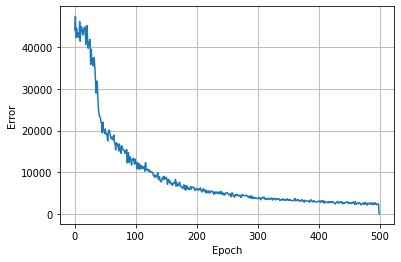

<Figure size 432x288 with 0 Axes>

In [33]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [34]:
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,network_3)
results.append(["NN_3",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+======================+================+================+=================+=================+=================+=============+=================+=================+
| Linear regression    |       10765.5  |    1.88684e+08 |         13736.2 |    -0.81852     |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Linear Ridge         |       14682.5  |    2.90253e+08 |         17036.8 |  -523.532       | 15361.8         | 3.11941e+08 | 17661.9         |  -633.494       |
+---------------------

##Quesion 5)
####Part 1
ReLU is a Rectified Linear Unit which is 0 if the input is less than 0, and equal to the input if the input is greater than 0. This provides better performance as sigmoid, and has all of its advantages. Having every value less than 0 go to 0, it causes some dying 'neurons'. The leakey ReLU has a decreasing positive slope for inputs less than 0. This solves the dying issue in ReLU. The sigmoid function takes the input and gives the probabilty that it is between 0 and 1. It's main advantage is that it's simple and easy to use, however, this can cause data loss and the vanishing gradient problem.

Part 2: Leaky ReLU performs better since it solves the dying issue in ReLU and has the same advantages as Sigmoid.

In [35]:
class mynetwork_4(nn.Module):
  def __init__(self):
    super(mynetwork_4, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160,100), nn.Sigmoid(), nn.Linear(100,80), nn.Sigmoid(), nn.Linear(80,50), nn.Sigmoid(), nn.Linear(50,1))

  def forward(self, x):
    x = self.structure(x)
    return x
  

In [36]:
model_4 = mynetwork_4().cuda()
network_4, losses = train(XTrain, yTrain, model_4, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.422e+04 time:    0.4
epoch:   40 training loss: 4.207e+04 time:    0.8
epoch:   60 training loss: 4.515e+04 time:    1.2
epoch:   80 training loss: 4.356e+04 time:    1.6
epoch:  100 training loss: 4.325e+04 time:    2.0
epoch:  120 training loss: 4.415e+04 time:    2.4
epoch:  140 training loss: 4.412e+04 time:    2.8
epoch:  160 training loss: 4.426e+04 time:    3.1
epoch:  180 training loss: 4.475e+04 time:    3.5
epoch:  200 training loss: 4.297e+04 time:    3.9
epoch:  220 training loss: 4.429e+04 time:    4.3
epoch:  240 training loss: 4.246e+04 time:    4.7
epoch:  260 training loss: 4.545e+04 time:    5.1
epoch:  280 training loss: 4.381e+04 time:    5.4
epoch:  300 training loss: 4.406e+04 time:    5.8
epoch:  320 training loss: 4.511e+04 time:    6.2
epoch:  340 training loss: 4.454e+04 time:    6.6
epoch:  360 training loss: 4.645e+04 time:    7.0
epoch:  380 training loss: 4.503e+04 time:    7.4
epoch:  400 training loss: 4.231e+04 time:    7.8


<Figure size 432x288 with 0 Axes>

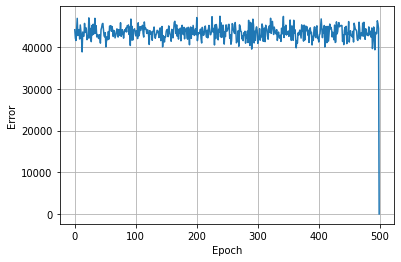

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [38]:
MAE_train_nn4,MSE_train_nn4,RMSE_train_nn4,R2_train_nn4,MAE_test_nn4,MSE_test_nn4,RMSE_test_nn4,R2_test_nn4=model_eva(XTrain,XTest,yTrain,yTest,network_4)
results.append(["NN_3_sigmoid",MAE_train_nn4,MSE_train_nn4,RMSE_train_nn4,R2_train_nn4,MAE_test_nn4,MSE_test_nn4,RMSE_test_nn4,R2_test_nn4])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+======================+================+================+=================+=================+=================+=============+=================+=================+
| Linear regression    |       10765.5  |    1.88684e+08 |         13736.2 |    -0.81852     |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Linear Ridge         |       14682.5  |    2.90253e+08 |         17036.8 |  -523.532       | 15361.8         | 3.11941e+08 | 17661.9         |  -633.494       |
+---------------------

In [39]:
class mynetwork_5(nn.Module):
  def __init__(self):
    super(mynetwork_5, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160,100), nn.ReLU(), nn.Linear(100,80), nn.ReLU(), nn.Linear(80,50), nn.ReLU(), nn.Linear(50,1))

  def forward(self, x):
    x = self.structure(x)
    return x
  

In [40]:
model_5 = mynetwork_5().cuda()
network_5, losses = train(XTrain, yTrain, model_5, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.380e+04 time:    0.4
epoch:   40 training loss: 2.803e+04 time:    0.8
epoch:   60 training loss: 2.070e+04 time:    1.2
epoch:   80 training loss: 1.738e+04 time:    1.6
epoch:  100 training loss: 1.510e+04 time:    2.0
epoch:  120 training loss: 1.296e+04 time:    2.4
epoch:  140 training loss: 1.156e+04 time:    2.8
epoch:  160 training loss: 1.066e+04 time:    3.2
epoch:  180 training loss: 8.482e+03 time:    3.5
epoch:  200 training loss: 7.449e+03 time:    3.9
epoch:  220 training loss: 6.202e+03 time:    4.3
epoch:  240 training loss: 5.929e+03 time:    4.7
epoch:  260 training loss: 4.991e+03 time:    5.1
epoch:  280 training loss: 5.162e+03 time:    5.5
epoch:  300 training loss: 4.129e+03 time:    5.9
epoch:  320 training loss: 4.499e+03 time:    6.3
epoch:  340 training loss: 4.243e+03 time:    6.7
epoch:  360 training loss: 4.064e+03 time:    7.1
epoch:  380 training loss: 4.001e+03 time:    7.5
epoch:  400 training loss: 3.913e+03 time:    7.9


<Figure size 432x288 with 0 Axes>

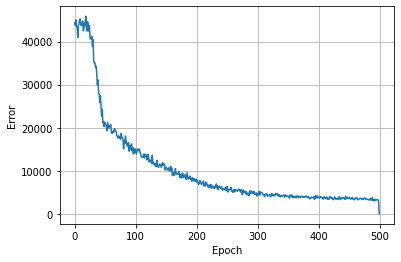

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [42]:
MAE_train_nn5,MSE_train_nn5,RMSE_train_nn5,R2_train_nn5,MAE_test_nn5,MSE_test_nn5,RMSE_test_nn5,R2_test_nn5=model_eva(XTrain,XTest,yTrain,yTest,network_5)
results.append(["NN_3_relu",MAE_train_nn5,MSE_train_nn5,RMSE_train_nn5,R2_train_nn5,MAE_test_nn5,MSE_test_nn5,RMSE_test_nn5,R2_test_nn5])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+======================+================+================+=================+=================+=================+=============+=================+=================+
| Linear regression    |       10765.5  |    1.88684e+08 |        13736.2  |    -0.81852     |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+----------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Linear Ridge         |       14682.5  |    2.90253e+08 |        17036.8  |  -523.532       | 15361.8         | 3.11941e+08 | 17661.9         |  -633.494       |
+---------------------

####Quesion 6)

In [43]:
class mynetwork_6(nn.Module):
  def __init__(self):
    super(mynetwork_6, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160, 100), nn.Sigmoid(), nn.Linear(100, 80), nn.ReLU(), nn.Linear(80,50), nn.LeakyReLU(), nn.Linear(50,1))
  
  def forward(self, x):
    x = self.structure(x)
    return x

In [44]:
class mynetwork_7(nn.Module):
  def __init__(self):
    super(mynetwork_7, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160, 100), nn.Sigmoid(), nn.Linear(100, 80), nn.ReLU(), nn.Linear(80,50), nn.LeakyReLU(), nn.Linear(50,50), nn.LeakyReLU(), nn.Linear(50,1))
  def forward(self, x):
    x = self.structure(x)
    return x

In [45]:
torch.manual_seed(50)

model_6 = mynetwork_6().cuda()
model_7 = mynetwork_7().cuda()


batch_size = 250
num_epochs = 1000
learning_rate = 1e-4
criterion = nn.MSELoss()

print_interval=20

In [46]:
network_6, losses = train(XTrain, yTrain, model_6, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.474e+04 time:    0.3
epoch:   40 training loss: 4.297e+04 time:    0.6
epoch:   60 training loss: 4.248e+04 time:    0.8
epoch:   80 training loss: 4.360e+04 time:    1.1
epoch:  100 training loss: 4.277e+04 time:    1.3
epoch:  120 training loss: 4.314e+04 time:    1.5
epoch:  140 training loss: 4.202e+04 time:    1.8
epoch:  160 training loss: 4.099e+04 time:    2.0
epoch:  180 training loss: 4.131e+04 time:    2.3
epoch:  200 training loss: 4.413e+04 time:    2.5
epoch:  220 training loss: 4.217e+04 time:    2.8
epoch:  240 training loss: 4.384e+04 time:    3.0
epoch:  260 training loss: 4.203e+04 time:    3.2
epoch:  280 training loss: 4.522e+04 time:    3.5
epoch:  300 training loss: 4.590e+04 time:    3.7
epoch:  320 training loss: 4.443e+04 time:    3.9
epoch:  340 training loss: 4.313e+04 time:    4.2
epoch:  360 training loss: 4.151e+04 time:    4.4
epoch:  380 training loss: 4.353e+04 time:    4.6
epoch:  400 training loss: 4.461e+04 time:    5.0


<Figure size 432x288 with 0 Axes>

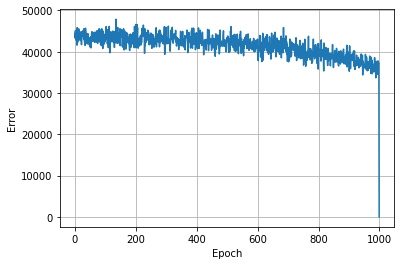

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [48]:
network_7, losses = train(XTrain, yTrain, model_7, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.339e+04 time:    0.3
epoch:   40 training loss: 4.273e+04 time:    0.5
epoch:   60 training loss: 4.364e+04 time:    0.8
epoch:   80 training loss: 4.164e+04 time:    1.1
epoch:  100 training loss: 4.116e+04 time:    1.4
epoch:  120 training loss: 4.054e+04 time:    1.6
epoch:  140 training loss: 4.040e+04 time:    1.9
epoch:  160 training loss: 4.281e+04 time:    2.2
epoch:  180 training loss: 4.486e+04 time:    2.5
epoch:  200 training loss: 4.120e+04 time:    2.8
epoch:  220 training loss: 4.355e+04 time:    3.0
epoch:  240 training loss: 4.313e+04 time:    3.3
epoch:  260 training loss: 4.220e+04 time:    3.6
epoch:  280 training loss: 4.409e+04 time:    3.9
epoch:  300 training loss: 4.021e+04 time:    4.1
epoch:  320 training loss: 3.888e+04 time:    4.4
epoch:  340 training loss: 3.897e+04 time:    4.7
epoch:  360 training loss: 4.066e+04 time:    5.0
epoch:  380 training loss: 3.738e+04 time:    5.2
epoch:  400 training loss: 3.593e+04 time:    5.5


<Figure size 432x288 with 0 Axes>

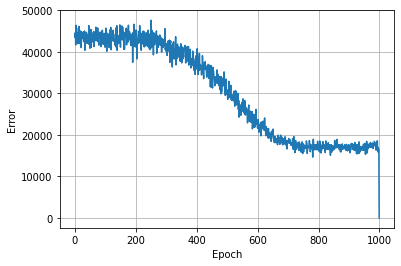

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [50]:
class mynetwork_8(nn.Module):
  def __init__(self):
    super(mynetwork_8, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160, 100), nn.LeakyReLU(), nn.Linear(100, 80), nn.ReLU(), nn.Linear(80,50), nn.LeakyReLU(), nn.Linear(50,50), nn.LeakyReLU(), nn.Linear(50,1))
  def forward(self, x):
    x = self.structure(x)
    return x

In [51]:
network_6, losses = train(XTrain, yTrain, model_6, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 3.657e+04 time:    0.2
epoch:   40 training loss: 3.581e+04 time:    0.5
epoch:   60 training loss: 3.612e+04 time:    0.7
epoch:   80 training loss: 3.591e+04 time:    1.0
epoch:  100 training loss: 3.572e+04 time:    1.2
epoch:  120 training loss: 3.466e+04 time:    1.5
epoch:  140 training loss: 3.506e+04 time:    1.7
epoch:  160 training loss: 3.555e+04 time:    1.9
epoch:  180 training loss: 3.512e+04 time:    2.2
epoch:  200 training loss: 3.316e+04 time:    2.4
epoch:  220 training loss: 3.298e+04 time:    2.7
epoch:  240 training loss: 3.349e+04 time:    2.9
epoch:  260 training loss: 3.040e+04 time:    3.2
epoch:  280 training loss: 3.325e+04 time:    3.4
epoch:  300 training loss: 2.996e+04 time:    3.7
epoch:  320 training loss: 2.964e+04 time:    3.9
epoch:  340 training loss: 3.020e+04 time:    4.2
epoch:  360 training loss: 3.048e+04 time:    4.5
epoch:  380 training loss: 2.633e+04 time:    4.7
epoch:  400 training loss: 2.937e+04 time:    5.0


<Figure size 432x288 with 0 Axes>

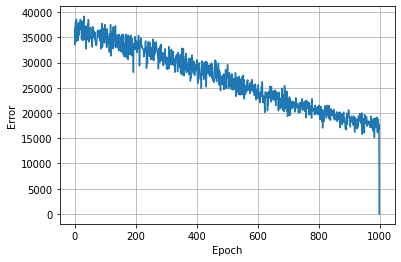

<Figure size 432x288 with 0 Axes>

In [52]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [53]:
torch.manual_seed(50)

#model_6 = mynetwork_6().cuda()
model_8 = mynetwork_8().cuda()


batch_size = 50
num_epochs = 2000
learning_rate = 1e-4
criterion = nn.MSELoss()

print_interval=100

In [54]:
network_6, losses = train(XTrain, yTrain, model_6, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 1.788e+04 time:    3.6
epoch:  200 training loss: 1.747e+04 time:    7.1
epoch:  300 training loss: 1.609e+04 time:   11.5
epoch:  400 training loss: 1.592e+04 time:   15.0
epoch:  500 training loss: 1.739e+04 time:   18.5
epoch:  600 training loss: 1.475e+04 time:   22.5
epoch:  700 training loss: 1.617e+04 time:   26.0
epoch:  800 training loss: 1.538e+04 time:   29.5
epoch:  900 training loss: 1.473e+04 time:   33.0
epoch: 1000 training loss: 1.375e+04 time:   36.5
epoch: 1100 training loss: 1.385e+04 time:   40.0
epoch: 1200 training loss: 1.371e+04 time:   43.6
epoch: 1300 training loss: 1.371e+04 time:   47.1
epoch: 1400 training loss: 1.379e+04 time:   50.6
epoch: 1500 training loss: 1.317e+04 time:   54.2
epoch: 1600 training loss: 1.257e+04 time:   57.7
epoch: 1700 training loss: 1.141e+04 time:   61.3
epoch: 1800 training loss: 1.051e+04 time:   64.8
epoch: 1900 training loss: 1.112e+04 time:   68.3


<Figure size 432x288 with 0 Axes>

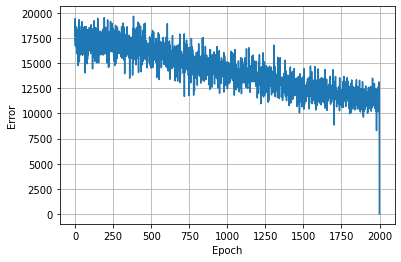

<Figure size 432x288 with 0 Axes>

In [55]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [56]:
network_8, losses = train(XTrain, yTrain, model_8, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 2.688e+04 time:    4.1
epoch:  200 training loss: 1.709e+04 time:    8.2
epoch:  300 training loss: 1.239e+04 time:   12.6
epoch:  400 training loss: 9.530e+03 time:   22.5
epoch:  500 training loss: 7.377e+03 time:   31.6
epoch:  600 training loss: 5.175e+03 time:   38.7
epoch:  700 training loss: 4.159e+03 time:   46.1
epoch:  800 training loss: 3.391e+03 time:   50.7
epoch:  900 training loss: 3.439e+03 time:   54.9
epoch: 1000 training loss: 2.927e+03 time:   58.9
epoch: 1100 training loss: 2.343e+03 time:   65.2
epoch: 1200 training loss: 2.109e+03 time:   69.5
epoch: 1300 training loss: 1.795e+03 time:   73.6
epoch: 1400 training loss: 1.498e+03 time:   77.6
epoch: 1500 training loss: 1.725e+03 time:   81.7
epoch: 1600 training loss: 1.127e+03 time:   85.7
epoch: 1700 training loss: 9.008e+02 time:   89.8
epoch: 1800 training loss: 8.257e+02 time:   93.8
epoch: 1900 training loss: 7.305e+02 time:   97.8


<Figure size 432x288 with 0 Axes>

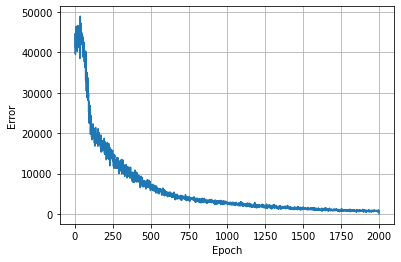

<Figure size 432x288 with 0 Axes>

In [57]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [58]:
MAE_train_nn6,MSE_train_nn6,RMSE_train_nn6,R2_train_nn6,MAE_test_nn6,MSE_test_nn6,RMSE_test_nn6,R2_test_nn6=model_eva(XTrain,XTest,yTrain,yTest,network_6)
MAE_train_nn7,MSE_train_nn7,RMSE_train_nn7,R2_train_nn7,MAE_test_nn7,MSE_test_nn7,RMSE_test_nn7,R2_test_nn7=model_eva(XTrain,XTest,yTrain,yTest,network_7)
MAE_train_nn8,MSE_train_nn8,RMSE_train_nn8,R2_train_nn8,MAE_test_nn8,MSE_test_nn8,RMSE_test_nn8,R2_test_nn8=model_eva(XTrain,XTest,yTrain,yTest,network_8)

results.append(["Your NN 1",MAE_train_nn6,MSE_train_nn6,RMSE_train_nn6,R2_train_nn6,MAE_test_nn6,MSE_test_nn6,RMSE_test_nn6,R2_test_nn6])
results.append(["Your NN 2",MAE_train_nn7,MSE_train_nn7,RMSE_train_nn7,R2_train_nn7,MAE_test_nn7,MSE_test_nn7,RMSE_test_nn7,R2_test_nn7])
results.append(["Your NN 3",MAE_train_nn8,MSE_train_nn8,RMSE_train_nn8,R2_train_nn8,MAE_test_nn8,MSE_test_nn8,RMSE_test_nn8,R2_test_nn8])


In [59]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+----------------------+----------------+------------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+======================+================+==================+=================+=================+=================+=============+=================+=================+
| Linear regression    |      10765.5   |      1.88684e+08 |        13736.2  |    -0.81852     |     1.27881e+06 | 1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+----------------------+----------------+------------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Linear Ridge         |      14682.5   |      2.90253e+08 |        17036.8  |  -523.532       | 15361.8         | 3.11941e+08 | 17661.9         |  -633.494       |
+---------

##Quesion 7)

<Figure size 432x288 with 0 Axes>

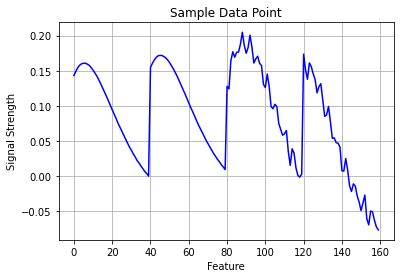

<Figure size 432x288 with 0 Axes>

In [60]:
plt.plot(XTrain[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

<Figure size 432x288 with 0 Axes>

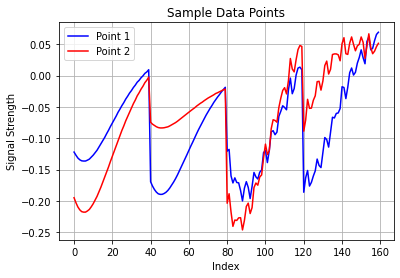

<Figure size 432x288 with 0 Axes>

In [61]:
plt.plot(x_norm[140], c='b', label='Point 1')
plt.plot(x_norm[141], c='r', label='Point 2')
plt.legend()
plt.grid()
py.xlabel("Index")
py.ylabel("Signal Strength")
py.title("Sample Data Points")
plt.figure()

In [62]:
def rotate(normedX):

    rows = normedX.shape[0]
    cols = normedX.shape[1]
    
    #rotate back
    angle_h = np.arctan(normedX[:,40]/normedX[:,0]).reshape((rows, 1))
    angle_v = np.arctan(normedX[:,120]/normedX[:,80]).reshape((rows, 1))
    
    realparts_h = normedX[:,0:40]
    imagparts_h = normedX[:,40:80]
    
    
    output = np.zeros_like(normedX)
    
    output[:,0:40] = np.cos(angle_h)*realparts_h + np.sin(angle_h) * imagparts_h
    output[:,40:80] = -np.sin(angle_h)*realparts_h + np.cos(angle_h) * imagparts_h
    
    
    realparts_v = normedX[:,80:120]
    imagpart_v = normedX[:,120:160]
    output[:,80:120] = np.cos(angle_v)*realparts_v + np.sin(angle_v) * imagpart_v
    output[:,120:160] = -np.sin(angle_v)*realparts_v + np.cos(angle_v) * imagpart_v
        
    output[:,0:80] = np.sign(output[:,0]).reshape((rows,1)) * output[:,0:80]
    output[:,80:160] = np.sign(output[:,80]).reshape((rows,1)) * output[:,80:160]
    
    return output

<Figure size 432x288 with 0 Axes>

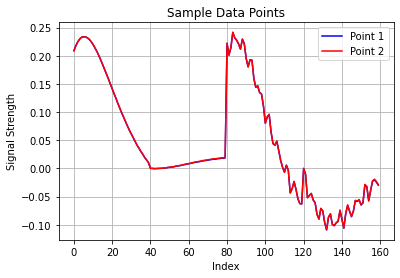

<Figure size 432x288 with 0 Axes>

In [63]:
plt.plot(rotate(x_norm)[140], c='b', label='Point 1')
plt.plot(rotate(x_norm)[141], c='r', label='Point 2')
plt.legend()
plt.grid()
py.xlabel("Index")
py.ylabel("Signal Strength")
py.title("Sample Data Points")
plt.figure()

In [64]:
network_8, losses = train(rotate(XTrain), yTrain, model_8, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 5.094e+03 time:    4.1
epoch:  200 training loss: 3.133e+03 time:    8.1
epoch:  300 training loss: 2.035e+03 time:   12.1
epoch:  400 training loss: 1.456e+03 time:   16.1
epoch:  500 training loss: 4.648e+02 time:   20.6
epoch:  600 training loss: 5.967e+02 time:   24.6
epoch:  700 training loss: 6.692e+02 time:   28.7
epoch:  800 training loss: 2.205e+02 time:   32.8
epoch:  900 training loss: 1.960e+02 time:   36.8
epoch: 1000 training loss: 1.705e+02 time:   40.8
epoch: 1100 training loss: 1.364e+02 time:   44.8
epoch: 1200 training loss: 9.510e+01 time:   48.9
epoch: 1300 training loss: 1.942e+02 time:   52.9
epoch: 1400 training loss: 9.347e+01 time:   56.9
epoch: 1500 training loss: 9.073e+01 time:   61.0
epoch: 1600 training loss: 7.977e+01 time:   65.1
epoch: 1700 training loss: 1.156e+02 time:   69.1
epoch: 1800 training loss: 9.622e+01 time:   73.1
epoch: 1900 training loss: 7.237e+01 time:   77.1


<Figure size 432x288 with 0 Axes>

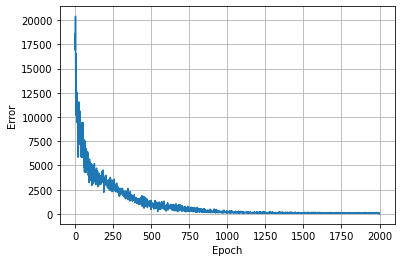

<Figure size 432x288 with 0 Axes>

In [65]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [66]:
MAE_train_nn8,MSE_train_nn8,RMSE_train_nn8,R2_train_nn8,MAE_test_nn8,MSE_test_nn8,RMSE_test_nn8,R2_test_nn8=model_eva(rotate(XTrain),rotate(XTest),yTrain,yTest,network_8)

results.append(["Your NN 3 with rotated X",MAE_train_nn8,MSE_train_nn8,RMSE_train_nn8,R2_train_nn8,MAE_test_nn8,MSE_test_nn8,RMSE_test_nn8,R2_test_nn8])

print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Model                    |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |        Test MSE |       Test RMSE |        Test R^2 |
+==========================+================+==================+=================+=================+=================+=================+=================+=================+
| Linear regression        |     10765.5    |      1.88684e+08 |      13736.2    |    -0.81852     |     1.27881e+06 |     1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Linear Ridge             |     14682.5    |      2.90253e+08 |      17036.8    |  -523.532       | 15361.8         |     3.11941e+08 

## Question 8)

In [72]:
arrays2 = {}

filepath = ['cs3data2.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        arrays2[k] = v

# display what data we have
for key in arrays2.keys():
    print(key, arrays2[key])

duct_height_save <HDF5 dataset "duct_height_save": shape (1, 4), type "<f8">
field_H_imag_save <HDF5 dataset "field_H_imag_save": shape (4, 1201, 40), type "<f8">
field_H_real_save <HDF5 dataset "field_H_real_save": shape (4, 1201, 40), type "<f8">
field_V_imag_save <HDF5 dataset "field_V_imag_save": shape (4, 1201, 40), type "<f8">
field_V_real_save <HDF5 dataset "field_V_real_save": shape (4, 1201, 40), type "<f8">
range_grid <HDF5 dataset "range_grid": shape (1201, 1), type "<f8">


In [73]:
duct_heights = np.array(arrays2['duct_height_save']).reshape(-1)
print(duct_heights)

[23.  23.5 24.  24.5]


In [74]:
numfields =  4
numranges = 1201

#get the electric field data and reshape everything into one np array

test_data_h_real = np.array(arrays2['field_H_real_save']).reshape(numfields, numranges, 40)
test_data_h_imag = np.array(arrays2['field_H_imag_save']).reshape(numfields, numranges, 40)
test_data_v_real = np.array(arrays2['field_V_real_save']).reshape(numfields, numranges, 40)
test_data_v_imag = np.array(arrays2['field_V_imag_save']).reshape(numfields, numranges, 40)

XTest_otherducts = []
XTest_otherducts += [[test_data_h_real*1, test_data_h_imag*1, test_data_v_real*1, test_data_v_imag*1]]
XTest_otherducts = np.block(XTest_otherducts)
print(XTest_otherducts.shape)

# get the target range data

ranges = np.array(arrays2['range_grid']).reshape((numranges))

yTest_otherducts = []
yTest_otherducts += [ranges]
yTest_otherducts = np.block(yTest_otherducts)
print(yTest_otherducts.shape)

(4, 1201, 160)
(1201,)


In [75]:
MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1=model_eva(XTrain,normalize(XTest_otherducts[0]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w2,MSE_train_nn3_w2,RMSE_train_nn3_w2,R2_train_nn3_w2,MAE_test_nn3_w2,MSE_test_nn3_w2,RMSE_test_nn3_w2,R2_test_nn3_w2=model_eva(XTrain,normalize(XTest_otherducts[1]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w3,MSE_train_nn3_w3,RMSE_train_nn3_w3,R2_train_nn3_w3,MAE_test_nn3_w3,MSE_test_nn3_w3,RMSE_test_nn3_w3,R2_test_nn3_w3=model_eva(XTrain,normalize(XTest_otherducts[2]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w4,MSE_train_nn3_w4,RMSE_train_nn3_w4,R2_train_nn3_w4,MAE_test_nn3_w4,MSE_test_nn3_w4,RMSE_test_nn3_w4,R2_test_nn3_w4=model_eva(XTrain,normalize(XTest_otherducts[3]),yTrain,yTest_otherducts,network_3)

In [76]:
results.append(["NN_3_weather_1",MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1])
results.append(["NN_3_weather_2",MAE_train_nn3_w2,MSE_train_nn3_w2,RMSE_train_nn3_w2,R2_train_nn3_w2,MAE_test_nn3_w2,MSE_test_nn3_w2,RMSE_test_nn3_w2,R2_test_nn3_w2])
results.append(["NN_3_weather_3",MAE_train_nn3_w3,MSE_train_nn3_w3,RMSE_train_nn3_w3,R2_train_nn3_w3,MAE_test_nn3_w3,MSE_test_nn3_w3,RMSE_test_nn3_w3,R2_test_nn3_w3])
results.append(["NN_3_weather_4",MAE_train_nn3_w4,MSE_train_nn3_w4,RMSE_train_nn3_w4,R2_train_nn3_w4,MAE_test_nn3_w4,MSE_test_nn3_w4,RMSE_test_nn3_w4,R2_test_nn3_w4])

In [77]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Model                    |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |        Test MSE |       Test RMSE |        Test R^2 |
+==========================+================+==================+=================+=================+=================+=================+=================+=================+
| Linear regression        |     10765.5    |      1.88684e+08 |      13736.2    |    -0.81852     |     1.27881e+06 |     1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Linear Ridge             |     14682.5    |      2.90253e+08 |      17036.8    |  -523.532       | 15361.8         |     3.11941e+08 


####Part 1
The model doesn't necessarily perform better in all weather, but rather inconsistently. The testing error between weather 1 and 4 is vastly different, weather 4 being much better. 

####Part 2

In [98]:
X_all = np.concatenate((Xraw, *XTest_otherducts))
print(X_all.shape)

Y_all = np.concatenate((yraw, np.repeat(yTest_otherducts, 4)))
print(Y_all.shape)

(6005, 160)
(6005,)


In [99]:
MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1=model_eva(XTrain,X_all,yTrain,Y_all,network_3)

In [100]:
results.append(["NN_3_All_Weather",MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1])

In [101]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Model                    |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |        Test MSE |       Test RMSE |        Test R^2 |
+==========================+================+==================+=================+=================+=================+=================+=================+=================+
| Linear regression        |     10765.5    |      1.88684e+08 |      13736.2    |    -0.81852     |     1.27881e+06 |     1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Linear Ridge             |     14682.5    |      2.90253e+08 |      17036.8    |  -523.532       | 15361.8         |     3.11941e+08 

In [103]:
MAE_train_nn8,MSE_train_nn8,RMSE_train_nn8,R2_train_nn8,MAE_test_nn8,MSE_test_nn8,RMSE_test_nn8,R2_test_nn8=model_eva(rotate(XTrain),rotate(X_all),yTrain,Y_all,network_8)

results.append(["Your NN 3 with rotated X and all weather",MAE_train_nn8,MSE_train_nn8,RMSE_train_nn8,R2_train_nn8,MAE_test_nn8,MSE_test_nn8,RMSE_test_nn8,R2_test_nn8])

print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+------------------------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Model                                    |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |        Test MSE |       Test RMSE |        Test R^2 |
+==========================================+================+==================+=================+=================+=================+=================+=================+=================+
| Linear regression                        |     10765.5    |      1.88684e+08 |      13736.2    |    -0.81852     |     1.27881e+06 |     1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+------------------------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Linear Ridge                             |     14682.

This did not improve our model at all, our testing error is really really bad. Compared to our original NN with rotated data, the testing error was at least 100 times worse. However, when tested on our best NN, it was slightly better. This is performing very well on our training data, however the large error in the testing data shows that our model is overfitting.

##Answer 9)

In [68]:
class mynetwork_10(nn.Module):
  def __init__(self):
    super(mynetwork_10, self).__init__()
    self.structure = nn.Sequential(nn.Linear(160, 100), nn.LeakyReLU(), nn.Linear(100, 80), nn.ReLU(), nn.Linear(80,50), nn.LeakyReLU(), nn.Linear(50,50), nn.LeakyReLU(), nn.Linear(50,1))
  def forward(self, x):
    x = self.structure(x)
    return x

In [69]:
m = nn.Dropout(p=0.2)
input = torch.randn(20, 16)
output = m(input)

model_10 = mynetwork_10().cuda()

batch_size = 50
num_epochs = 2000
learning_rate = 1e-4
criterion = nn.MSELoss()

print_interval=100

In [70]:
network_10, losses = train(rotate(XTrain), yTrain, model_10, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 2.039e+04 time:    7.5
epoch:  200 training loss: 1.191e+04 time:   14.2
epoch:  300 training loss: 9.553e+03 time:   21.4
epoch:  400 training loss: 8.113e+03 time:   31.9
epoch:  500 training loss: 9.298e+03 time:   39.1
epoch:  600 training loss: 8.286e+03 time:   46.4
epoch:  700 training loss: 8.695e+03 time:   53.4
epoch:  800 training loss: 6.395e+03 time:   60.5
epoch:  900 training loss: 7.972e+03 time:   64.6
epoch: 1000 training loss: 6.276e+03 time:   68.6
epoch: 1100 training loss: 8.061e+03 time:   72.6
epoch: 1200 training loss: 6.952e+03 time:   76.5
epoch: 1300 training loss: 6.658e+03 time:   80.9
epoch: 1400 training loss: 7.309e+03 time:   85.0
epoch: 1500 training loss: 6.311e+03 time:   88.9
epoch: 1600 training loss: 5.270e+03 time:   92.9
epoch: 1700 training loss: 5.534e+03 time:   96.9
epoch: 1800 training loss: 7.130e+03 time:  101.0
epoch: 1900 training loss: 6.791e+03 time:  105.1


<Figure size 432x288 with 0 Axes>

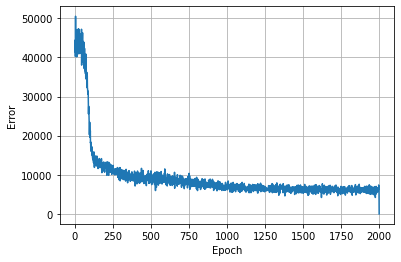

<Figure size 432x288 with 0 Axes>

In [71]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [72]:
MAE_train_nn10,MSE_train_nn10,RMSE_train_nn10,R2_train_nn10,MAE_test_nn10,MSE_test_nn10,RMSE_test_nn10,R2_test_nn10=model_eva(rotate(XTrain),rotate(XTest),yTrain,yTest,network_10)

In [73]:
results.append(["Our NN3 with Dropout",MAE_train_nn10,MSE_train_nn10,RMSE_train_nn10,R2_train_nn10,MAE_test_nn10,MSE_test_nn10,RMSE_test_nn10,R2_test_nn10])

print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Model                    |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |        Test MSE |       Test RMSE |        Test R^2 |
+==========================+================+==================+=================+=================+=================+=================+=================+=================+
| Linear regression        |     10765.5    |      1.88684e+08 |      13736.2    |    -0.81852     |     1.27881e+06 |     1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Linear Ridge             |     14682.5    |      2.90253e+08 |      17036.8    |  -523.532       | 15361.8         |     3.11941e+08 

In [74]:
m = nn.BatchNorm1d(100)
m = nn.BatchNorm1d(100, affine=False)
input = torch.randn(20, 100)
output = m(input)

model_10 = mynetwork_10().cuda()

batch_size = 50
num_epochs = 2000
learning_rate = 1e-4
criterion = nn.MSELoss()

print_interval=100

In [75]:
network_10, losses = train(rotate(XTrain), yTrain, model_10, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 1.531e+04 time:    4.4
epoch:  200 training loss: 1.143e+04 time:    8.4
epoch:  300 training loss: 9.303e+03 time:   12.4
epoch:  400 training loss: 7.964e+03 time:   16.4
epoch:  500 training loss: 8.272e+03 time:   20.4
epoch:  600 training loss: 9.487e+03 time:   24.4
epoch:  700 training loss: 6.698e+03 time:   28.4
epoch:  800 training loss: 7.871e+03 time:   32.4
epoch:  900 training loss: 6.644e+03 time:   36.4
epoch: 1000 training loss: 7.069e+03 time:   40.5
epoch: 1100 training loss: 5.657e+03 time:   44.5
epoch: 1200 training loss: 6.870e+03 time:   48.5
epoch: 1300 training loss: 7.260e+03 time:   52.5
epoch: 1400 training loss: 6.353e+03 time:   56.4
epoch: 1500 training loss: 5.875e+03 time:   60.4
epoch: 1600 training loss: 6.357e+03 time:   64.4
epoch: 1700 training loss: 4.106e+03 time:   68.4
epoch: 1800 training loss: 5.993e+03 time:   72.4
epoch: 1900 training loss: 6.334e+03 time:   76.8


<Figure size 432x288 with 0 Axes>

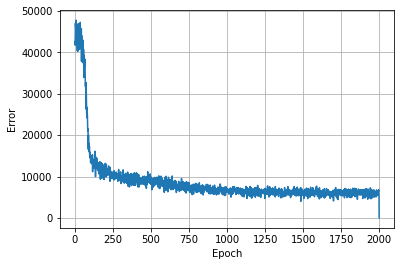

<Figure size 432x288 with 0 Axes>

In [76]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [77]:
MAE_train_nn10,MSE_train_nn10,RMSE_train_nn10,R2_train_nn10,MAE_test_nn10,MSE_test_nn10,RMSE_test_nn10,R2_test_nn10=model_eva(rotate(XTrain),rotate(XTest),yTrain,yTest,network_10)

In [78]:
results.append(["Our NN3 with BatchNorm",MAE_train_nn10,MSE_train_nn10,RMSE_train_nn10,R2_train_nn10,MAE_test_nn10,MSE_test_nn10,RMSE_test_nn10,R2_test_nn10])

print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Model                    |   Training MAE |     Training MSE |   Training RMSE |    Training R^2 |        Test MAE |        Test MSE |       Test RMSE |        Test R^2 |
+==========================+================+==================+=================+=================+=================+=================+=================+=================+
| Linear regression        |     10765.5    |      1.88684e+08 |      13736.2    |    -0.81852     |     1.27881e+06 |     1.35899e+14 |     1.16576e+07 |    -0.000280507 |
+--------------------------+----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Linear Ridge             |     14682.5    |      2.90253e+08 |      17036.8    |  -523.532       | 15361.8         |     3.11941e+08 